# CPPN Example

In [ ]:
%pip install ribs[visualize] torch

In [2]:
import sys
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom activation functions
def sine(x):
    return torch.sin(x)

def gaussian(x):
    return torch.exp(-x**2)

# Dictionary of activations
activation_dict = {
    'tanh': torch.tanh,
    'relu': F.relu,
    'sigmoid': torch.sigmoid,
    'sine': sine,
    'gaussian': gaussian,
}

class CPPNLayer(nn.Module):
    """Basic CPPN Layer with configurable activation."""
    def __init__(self, in_dim, out_dim, activation='tanh'):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = activation_dict[activation]

    def forward(self, x):
        return self.activation(self.linear(x))

class CPPN(nn.Module):
    """Full CPPN network."""
    def __init__(self, input_dim=3, hidden_dim=32, num_hidden_layers=8, activation='tanh'):
        super().__init__()
        self.layers = nn.ModuleList()
        dims = [input_dim] + [hidden_dim] * num_hidden_layers + [1]

        for i in range(len(dims) - 1):
            self.layers.append(CPPNLayer(dims[i], dims[i+1], activation=activation))

    def forward(self, coords):
        x = coords
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
def generate_coordinates(width, height):
    """Generates input grid coordinates."""
    xs = np.linspace(-1, 1, width)
    ys = np.linspace(-1, 1, height)
    x_coords, y_coords = np.meshgrid(xs, ys)
    r_coords = np.sqrt(x_coords**2 + y_coords**2)
    coords = np.stack([x_coords, y_coords, r_coords], axis=-1)
    return torch.tensor(coords.reshape(-1, 3), dtype=torch.float32)

def generate_image(model, width=256, height=256):
    """Generates and displays image."""
    coords = generate_coordinates(width, height)
    with torch.no_grad():
        output = model(coords).reshape(height, width).cpu().numpy()
    return output

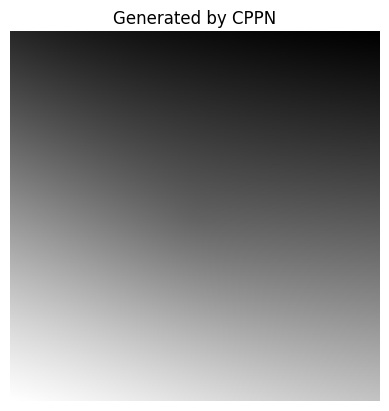

In [5]:
# Create and visualize
cppn = CPPN()
image = generate_image(cppn)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Generated by CPPN")
plt.show()

In [6]:
from torch.nn.utils import vector_to_parameters

# TODO: rename?
def evaluate_cppn_batch(solutions, cppn_template, width=64, height=64, device="cpu"):
    """Evaluates a batch of CPPN parameter vectors and returns generated images.

    Args:
        solutions (np.ndarray): Shape (batch_size, num_params). Flat parameters.
        cppn_template (nn.Module): An uninitialized CPPN model with the right architecture.
        width (int): Output image width.
        height (int): Output image height.
        device (str): Device to use ("cpu" or "cuda").

    Returns:
        np.ndarray: Shape (batch_size, height, width). Grayscale images.
    """
    batch_size, num_params = solutions.shape
    images = []

    coords = generate_coordinates(width, height).to(device)  # Shape (H*W, 3)

    for i in range(batch_size):
        cppn = CPPN(**cppn_template).to(device)  # Create a new CPPN instance
        flat_params = torch.tensor(solutions[i], dtype=torch.float32, device=device)

        # Load flat params into model
        vector_to_parameters(flat_params, cppn.parameters())

        # Generate image
        with torch.no_grad():
            output = cppn(coords).reshape(height, width).cpu().numpy()
        images.append(output)

    return np.stack(images)  # Shape (batch_size, H, W)

In [7]:
from torch.nn.utils import parameters_to_vector

cppn_template = dict(input_dim=3, hidden_dim=32, num_hidden_layers=3)

# Create a dummy model to get parameter count.
solution_dim = parameters_to_vector(CPPN(**cppn_template).parameters()).numel()
print("solution_dim:", solution_dim)

solution_dim: 2273


In [8]:
from ribs.archives import DensityArchive

archive = DensityArchive(measure_dim=2,
                         buffer_size=10000,
                         density_method="kde",
                         bandwidth=25.6)

In [9]:
from ribs.archives import GridArchive

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=(100, 100),
                             ranges=[(-1, 1), (-1, 1)])

# TODO: ranges

In [10]:
from ribs.emitters import EvolutionStrategyEmitter

# TODO: Talk about taking in result_archive
# TODO: x0?

# Notes:
# - ranker="density" indicates that the emitter will rank solutions by their density
emitters = [
    EvolutionStrategyEmitter(
        result_archive,
        x0=np.zeros(solution_dim),
        sigma0=1.5,
        ranker="density",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=30,
    ) for _ in range(5)
]

In [11]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive)

In [12]:
# TODO: more iterations
total_itrs = 50

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solutions = scheduler.ask()

    images = evaluate_cppn_batch(solutions, cppn_template)
    
    # TODO: compute objective and measures
    objectives = np.zeros(len(images))
    measures = np.random.standard_normal((len(images), 2))
    
    scheduler.tell(objectives, measures)

    # Logging.
    if itr % 100 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Size: {result_archive.stats.num_elites} "
                   f"Coverage: {result_archive.stats.coverage * 100:6.3f}%")

Iteration    50 | Size: 3222 Coverage: 32.220%                                    
Iterations: 100%|█████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


In [13]:
import itertools

# TODO: Remove mention of Age and Hair Length

# Modify this to determine how many images to plot along each dimension.
img_freq = (
    8,  # Number of columns of images (i.e. along the "Age" axis).
    8,  # Number of rows of images (i.e. along the "Hair Length" axis).
)

# List of images.
imgs = []

# Convert archive to a df with solutions available.
df = result_archive.data(return_type="pandas")

# Compute the min and max measures for which solutions were found.
measure_bounds = [
    (df['measures_0'].min(), df['measures_0'].max()),
    (df['measures_1'].min(), df['measures_1'].max()),
]
delta_measures_0 = (measure_bounds[0][1] - measure_bounds[0][0]) / img_freq[0]
delta_measures_1 = (measure_bounds[1][1] - measure_bounds[1][0]) / img_freq[1]

for col, row in itertools.product(range(img_freq[1]), range(img_freq[0])):
    # Compute bounds of a box in measure space.
    measures_0_low = measure_bounds[0][0] + delta_measures_0 * row
    measures_0_high = measure_bounds[0][0] + delta_measures_0 * (row + 1)
    measures_1_low = measure_bounds[1][0] + delta_measures_1 * col
    measures_1_high = measure_bounds[1][0] + delta_measures_1 * (col + 1)

    # Query for a solution with measures within this box.
    df_box = df[(measures_0_low <= df['measures_0']) & (df['measures_0'] < measures_0_high) &
                (measures_1_low <= df['measures_1']) & (df['measures_1'] < measures_1_high)]

    if not df_box.empty:
        # TODO: use rng?
        # Select random solution in the box.
        idx = np.random.choice(len(df_box['objective']))
        
        sol = np.asarray(df_box.loc[:, "solution_0":f"solution_{solution_dim - 1}"].iloc[idx])
        
        img = evaluate_cppn_batch(sol[None], cppn_template)[0]
        imgs.append(torch.tensor(img[None, None]))
    else:
        imgs.append(torch.zeros((1, 1, 64, 64))) # TODO: make width and height be params somewhere

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


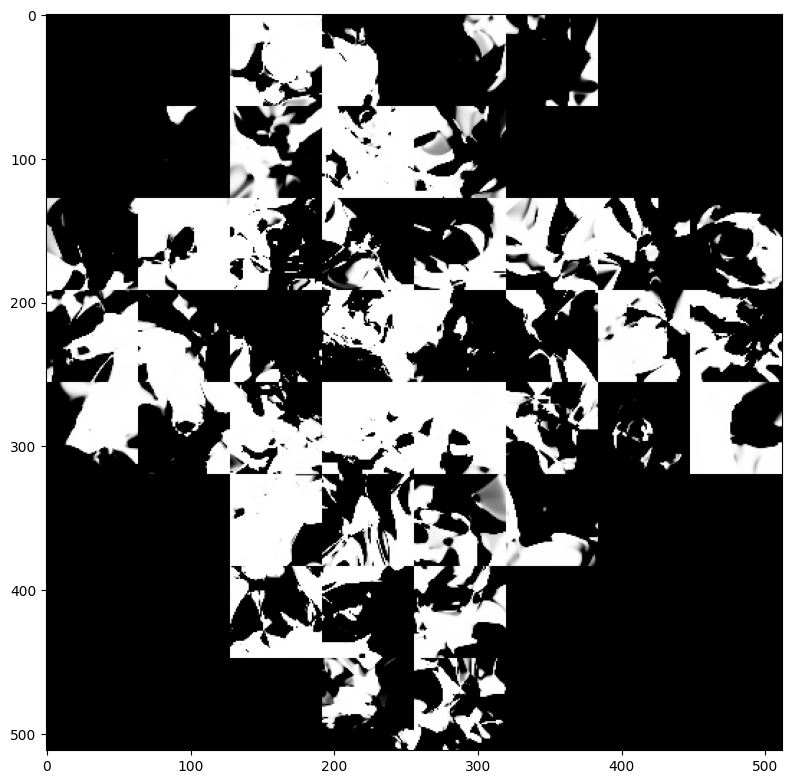

In [14]:
def create_archive_tick_labels(measure_range, num_ticks):
    delta = (measure_range[1] - measure_range[0]) / num_ticks
    ticklabels = [
        round(delta * p + measure_range[0], 3) for p in range(num_ticks + 1)
    ]
    return ticklabels


plt.figure(figsize=img_freq)
img_grid = make_grid(torch.cat(imgs, axis=0), nrow=img_freq[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1, 2, 0))
plt.imshow(img_grid)

# plt.xlabel("Age")
# num_x_ticks = img_freq[0]
# x_ticklabels = create_archive_tick_labels(measure_bounds[0], num_x_ticks)
# x_tick_range = img_grid.shape[1]
# x_ticks = np.arange(0, x_tick_range + 1e-9, step=x_tick_range / num_x_ticks)
# plt.xticks(x_ticks, x_ticklabels)

# plt.ylabel("Hair Length")
# num_y_ticks = img_freq[1]
# y_ticklabels = create_archive_tick_labels(measure_bounds[1], num_y_ticks)
# y_ticklabels.reverse()
# y_tick_range = img_grid.shape[0]
# y_ticks = np.arange(0, y_tick_range + 1e-9, step=y_tick_range / num_y_ticks)
# plt.yticks(y_ticks, y_ticklabels)

plt.tight_layout()